In [1]:
import quadpy
import scipy
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = "retina"

def kelvin_point_source_stress(x, y, xoffset, yoffset, fx, fy, mu, nu):
    x = x - xoffset
    y = y - yoffset
    C = 1 / (4 * np.pi * (1 - nu))
    gx = -C * x / (x**2 + y**2)
    gy = -C * y / (x**2 + y**2)
    gxy = C * 2 * x * y / (x**2 + y**2) ** 2
    gxx = C * (x**2 - y**2) / (x**2 + y**2) ** 2
    gyy = -gxx
    sxx = fx * (2 * (1 - nu) * gx - x * gxx) + fy * (2 * nu * gy - y * gxx)
    syy = fx * (2 * nu * gx - x * gyy) + fy * (2 * (1 - nu) * gy - y * gyy)
    sxy = fx * ((1 - 2 * nu) * gy - x * gxy) + fy * ((1 - 2 * nu) * gx - y * gxy)
    return sxx, syy, sxy


def kelvin_point_source_disp(x, y, xoffset, yoffset, fx, fy, mu, nu):
    x = x - xoffset
    y = y - yoffset
    C = 1 / (4 * np.pi * (1 - nu))
    r = np.sqrt(x**2 + y**2)
    g = -C * np.log(r)
    gx = -C * x / (x**2 + y**2)
    gy = -C * y / (x**2 + y**2)
    ux = fx / (2 * mu) * ((3 - 4 * nu) * g - x * gx) + fy / (2 * mu) * (-y * gx)
    uy = fx / (2 * mu) * (-x * gy) + fy / (2 * mu) * ((3 - 4 * nu) * g - y * gy)
    return ux, uy


def get_triangle_area(lx, ly, dly):
    # Calculate the lengths of the sides of the triangle
    a = np.sqrt((lx - 0) ** 2 + (dly - 0) ** 2)
    b = np.sqrt((0 - lx) ** 2 + (ly - dly) ** 2)
    c = np.sqrt((0 - 0) ** 2 + (0 - ly) ** 2)

    # Calculate the semi-perimeter of the triangle
    s = (a + b + c) / 2

    # Calculate the area of the triangle using Heron's formula
    triangle_area = np.sqrt(s * (s - a) * (s - b) * (s - c))
    return triangle_area


def get_transformed_coordinates(vertices, obs_x, obs_y):
    # Translate the triangle so that the first vertex is at the origin
    translated_vertices = vertices - np.array(vertices[0])
    translated_obs_x = obs_x - vertices[0, 0]
    translated_obs_y = obs_y - vertices[0, 1]

    # Determine the angle to rotate the second vertex to align with the y-axis
    second_vertex = translated_vertices[1]
    angle = np.arctan2(second_vertex[0], second_vertex[1])

    # Rotation matrix to align the second vertex along the positive y-axis
    rotation_matrix = np.array(
        [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
    )
    rotated_vertices = np.dot(translated_vertices, rotation_matrix.T)
    rotated_obs = np.dot(
        np.array([translated_obs_x, translated_obs_y]).T, rotation_matrix.T
    )

    return rotated_vertices, rotated_obs[:, 0], rotated_obs[:, 1]


def rotate_vector(vertices, fx, fy, rotdir=1):
    angle = (
        np.arctan2(vertices[1, 0] - vertices[0, 0], vertices[1, 1] - vertices[0, 1])
    ) * rotdir
    # print(np.rad2deg(angle))

    # Rotation matrix to align the second vertex along the positive y-axis
    rotation_matrix = np.array(
        [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
    )
    rotated_vector = np.dot(np.hstack([fx, fy]), rotation_matrix.T)
    fx_rotated = rotated_vector[:, 0]
    fy_rotated = rotated_vector[:, 1]

    return fx_rotated, fy_rotated


def rotate_stresses(vertices, sxx, syy, sxy, rotdir=1):
    npts = np.shape(sxx)[0]
    # Determine the angle to rotate the second vertex to align with the y-axis
    angle = (
        np.arctan2(vertices[1, 0] - vertices[0, 0], vertices[1, 1] - vertices[0, 1])
        * rotdir
    )

    # Rotation matrix to align the second vertex along the positive y-axis
    rotation_matrix = np.array(
        [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
    )

    stress_tensor = np.zeros((npts, 2, 2))
    stress_tensor[:, 0, 0] = sxx  # \sigma_{xx}
    stress_tensor[:, 1, 1] = syy  # \sigma_{yy}
    stress_tensor[:, 0, 1] = sxy  # \sigma_{xy}
    stress_tensor[:, 1, 0] = sxy  # \sigma_{xy}

    R_sigma = np.tensordot(stress_tensor, rotation_matrix, axes=([2], [0]))

    # Step 2: Compute (R @ sigma) @ R^T
    rotated_stress = np.tensordot(rotation_matrix.T, R_sigma, axes=([1], [1]))

    # Transpose the resulting array to get the correct shape
    rotated_stress = rotated_stress.transpose(1, 0, 2)

    sxx_rot = rotated_stress[:, 0, 0]
    syy_rot = rotated_stress[:, 1, 1]
    sxy_rot = rotated_stress[:, 0, 1]

    return sxx_rot, syy_rot, sxy_rot


def get_displacements_stresses_nearfield(triangle, x_obs, y_obs, fx, fy, mu, nu):
    # Shape forces
    fx = np.array([fx])[:, None]
    fy = np.array([fy])[:, None]

    # Translate and rotate the triangle
    triangle_transformed, obs_x_transformed, obs_y_transformed = (
        get_transformed_coordinates(triangle, x_obs.flatten(), y_obs.flatten())
    )

    # Rotated force vector
    fx_rot, fy_rot = rotate_vector(triangle, fx, fy)

    # Define a triangle region in dblquad style
    lx = triangle_transformed[2, 0]
    dly = triangle_transformed[2, 1]
    ly = triangle_transformed[1, 1]

    triangle_area = get_triangle_area(lx, ly, dly)

    # Definition of integration limits over a triangle and integrate using rotated forces
    ymin = lambda x: dly * x / lx
    ymax = lambda x: ly - (ly - dly) * x / lx

    ux_dblquad = np.zeros_like(obs_x_transformed).flatten()
    uy_dblquad = np.zeros_like(obs_x_transformed).flatten()
    sxx_dblquad = np.zeros_like(obs_x_transformed).flatten()
    syy_dblquad = np.zeros_like(obs_x_transformed).flatten()
    sxy_dblquad = np.zeros_like(obs_x_transformed).flatten()

    for i in range(0, obs_x_transformed.size):
        # ux velocity integration
        f = lambda y, x: kelvin_point_source_disp(
            obs_x_transformed.flatten()[i],
            obs_y_transformed.flatten()[i],
            x,
            y,
            fx_rot,
            fy_rot,
            mu,
            nu,
        )[0]
        sol, err = scipy.integrate.dblquad(f, 0, lx, ymin, ymax, epsabs=1e-3)
        if lx < 0:
            ux_dblquad[i] = -sol / triangle_area
        else:
            ux_dblquad[i] = sol / triangle_area

        # uy velocity integration
        f = lambda y, x: kelvin_point_source_disp(
            obs_x_transformed.flatten()[i],
            obs_y_transformed.flatten()[i],
            x,
            y,
            fx_rot,
            fy_rot,
            mu,
            nu,
        )[1]
        sol, err = scipy.integrate.dblquad(f, 0, lx, ymin, ymax, epsabs=1e-3)
        if lx < 0:
            uy_dblquad[i] = -sol / triangle_area
        else:
            uy_dblquad[i] = sol / triangle_area

        # xx stress integration
        f = lambda y, x: kelvin_point_source_stress(
            obs_x_transformed.flatten()[i],
            obs_y_transformed.flatten()[i],
            x,
            y,
            fx_rot,
            fy_rot,
            mu,
            nu,
        )[0]
        sol, err = scipy.integrate.dblquad(f, 0, lx, ymin, ymax, epsabs=1e-3)
        sxx_dblquad[i] = sol / triangle_area

        # yy stress integration
        f = lambda y, x: kelvin_point_source_stress(
            obs_x_transformed.flatten()[i],
            obs_y_transformed.flatten()[i],
            x,
            y,
            fx_rot,
            fy_rot,
            mu,
            nu,
        )[1]
        sol, err = scipy.integrate.dblquad(f, 0, lx, ymin, ymax, epsabs=1e-3)
        syy_dblquad[i] = sol / triangle_area

        # xy stress integration
        f = lambda y, x: kelvin_point_source_stress(
            obs_x_transformed.flatten()[i],
            obs_y_transformed.flatten()[i],
            x,
            y,
            fx_rot,
            fy_rot,
            mu,
            nu,
        )[2]
        sol, err = scipy.integrate.dblquad(f, 0, lx, ymin, ymax, epsabs=1e-3)
        sxy_dblquad[i] = sol / triangle_area

    # Rotate back to original coordinates
    ux, uy = rotate_vector(
        triangle,
        ux_dblquad.reshape(-1, 1),
        uy_dblquad.reshape(-1, 1),
        -1,
    )

    sxx, syy, sxy = rotate_stresses(
        triangle,
        sxx_dblquad,
        syy_dblquad,
        sxy_dblquad,
        -1,
    )
    return ux, uy, sxx, syy, sxy


def get_displacements_stresses_farfield(triangle, x_obs, y_obs, fx, fy, mu, nu):
    ux = np.zeros_like(x_obs)
    uy = np.zeros_like(x_obs)
    sxx = np.zeros_like(x_obs)
    syy = np.zeros_like(x_obs)
    sxy = np.zeros_like(x_obs)

    # quadpy integration scheme
    scheme = quadpy.t2.get_good_scheme(20)
    points_new = np.dot(triangle.T, scheme.points)
    n_integration_pts = len(scheme.weights)

    for i in range(n_integration_pts):
        ux_i, uy_i = kelvin_point_source_disp(
            x_obs.flatten(),
            y_obs.flatten(),
            points_new[0, i],
            points_new[1, i],
            fx,
            fy,
            mu,
            nu,
        )
        ux += scheme.weights[i] * ux_i
        uy += scheme.weights[i] * uy_i

        sxx_i, syy_i, sxy_i = kelvin_point_source_stress(
            x_obs.flatten(),
            y_obs.flatten(),
            points_new[0, i],
            points_new[1, i],
            fx,
            fy,
            mu,
            nu,
        )
        sxx += scheme.weights[i] * sxx_i
        syy += scheme.weights[i] * syy_i
        sxy += scheme.weights[i] * sxy_i
    return ux, uy, sxx, syy, sxy



# Model parameters

In [2]:
# Reference triangle geometry
triangle = np.array([[-0.5, 0.5], [2.0, 1.0], [0.5, 2.0]])

# Observation coordinates
x_obs, y_obs = np.meshgrid(np.linspace(-10, 10, 30), np.linspace(-10, 10, 30))
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# Forces
fx = 1.0
fy = 1.0

# Elastic parameters
mu = 1.0
nu = 0.25

# Near-field numerical integration using `scipy.integrate.dblquad`

In [3]:
ux_near, uy_near, sxx_near, syy_near, sxy_near = get_displacements_stresses_nearfield(
    triangle, x_obs, y_obs, fx, fy, mu, nu
)

# Far-field numerical integration using `quadpy`

In [4]:
ux_far, uy_far, sxx_far, syy_far, sxy_far = get_displacements_stresses_farfield(
    triangle, x_obs, y_obs, fx, fy, mu, nu
)

# TODO: Discuss with Rishav
sxx_far *= -1
syy_far *= -1
sxy_far *= -1

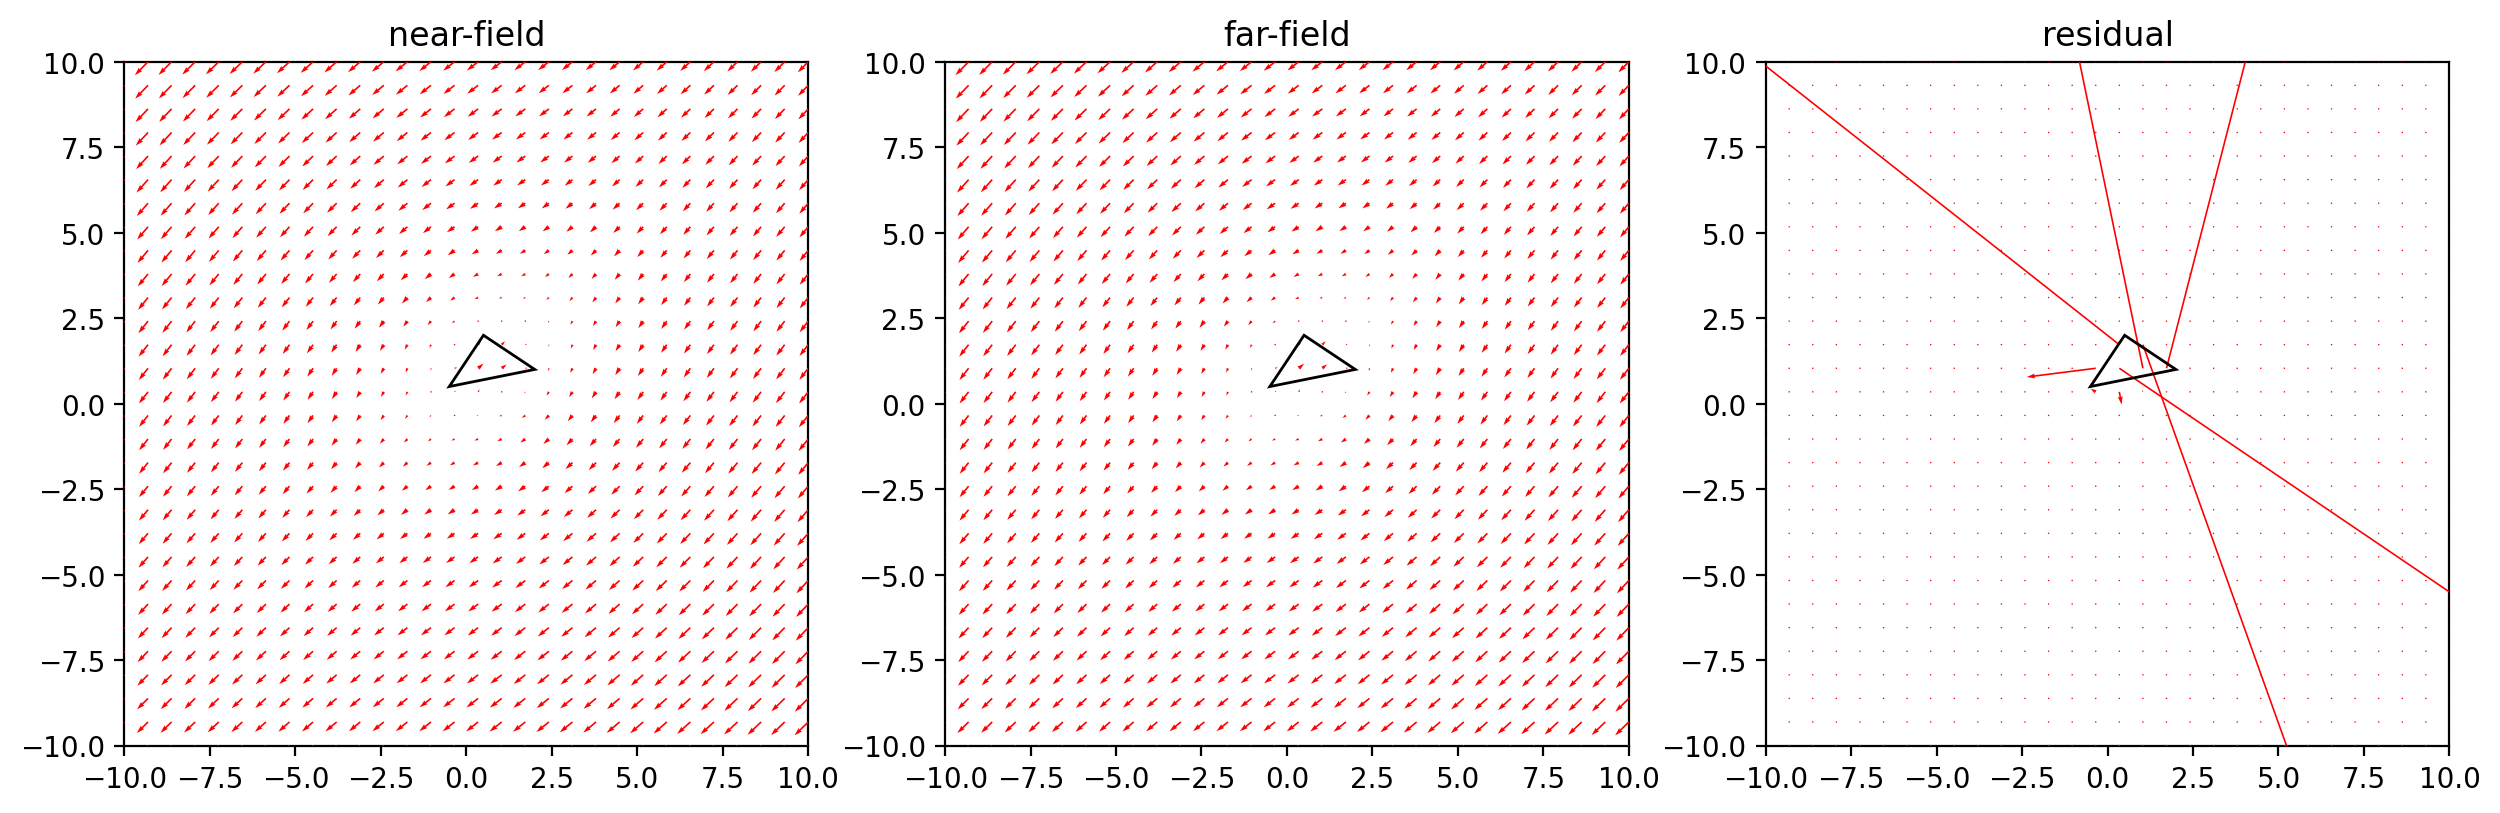

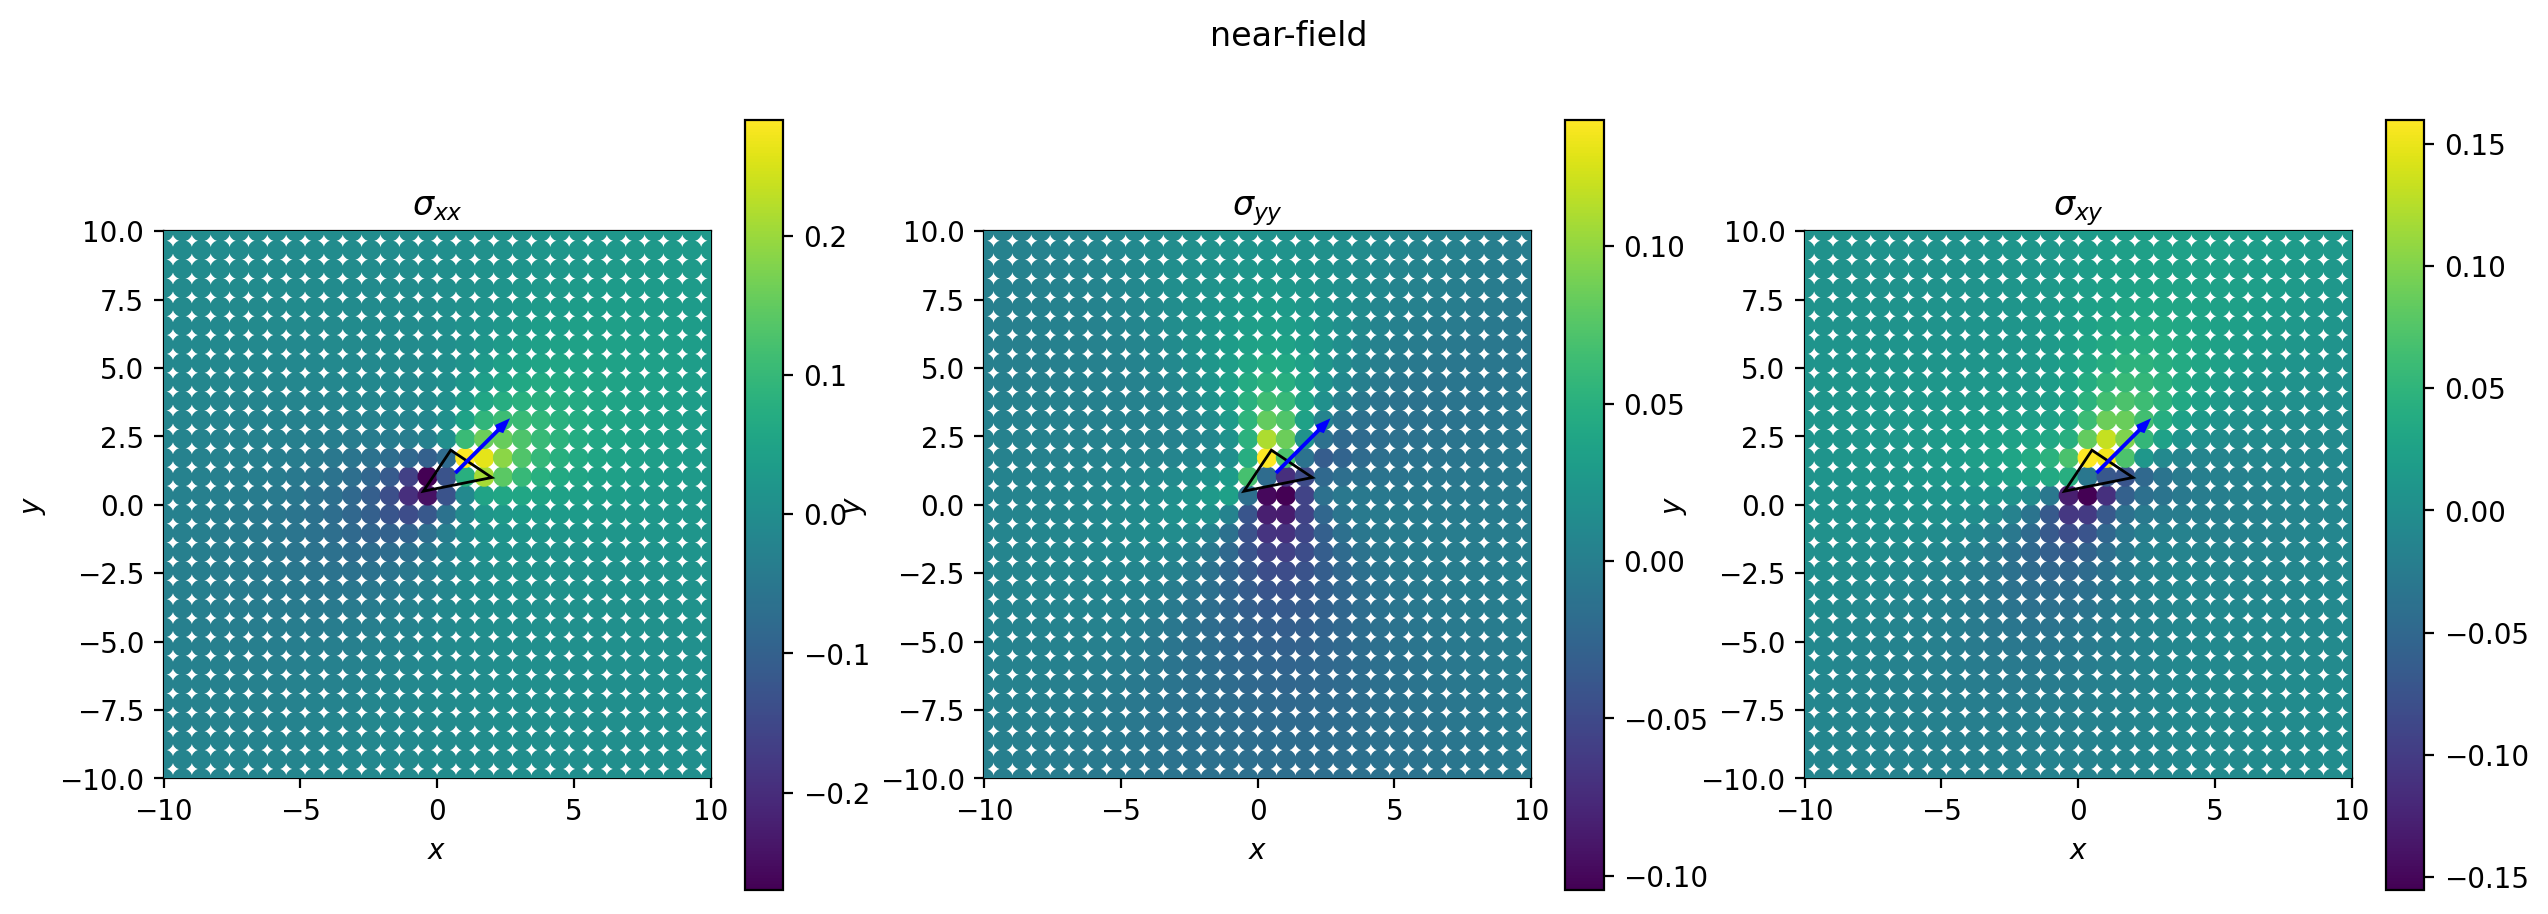

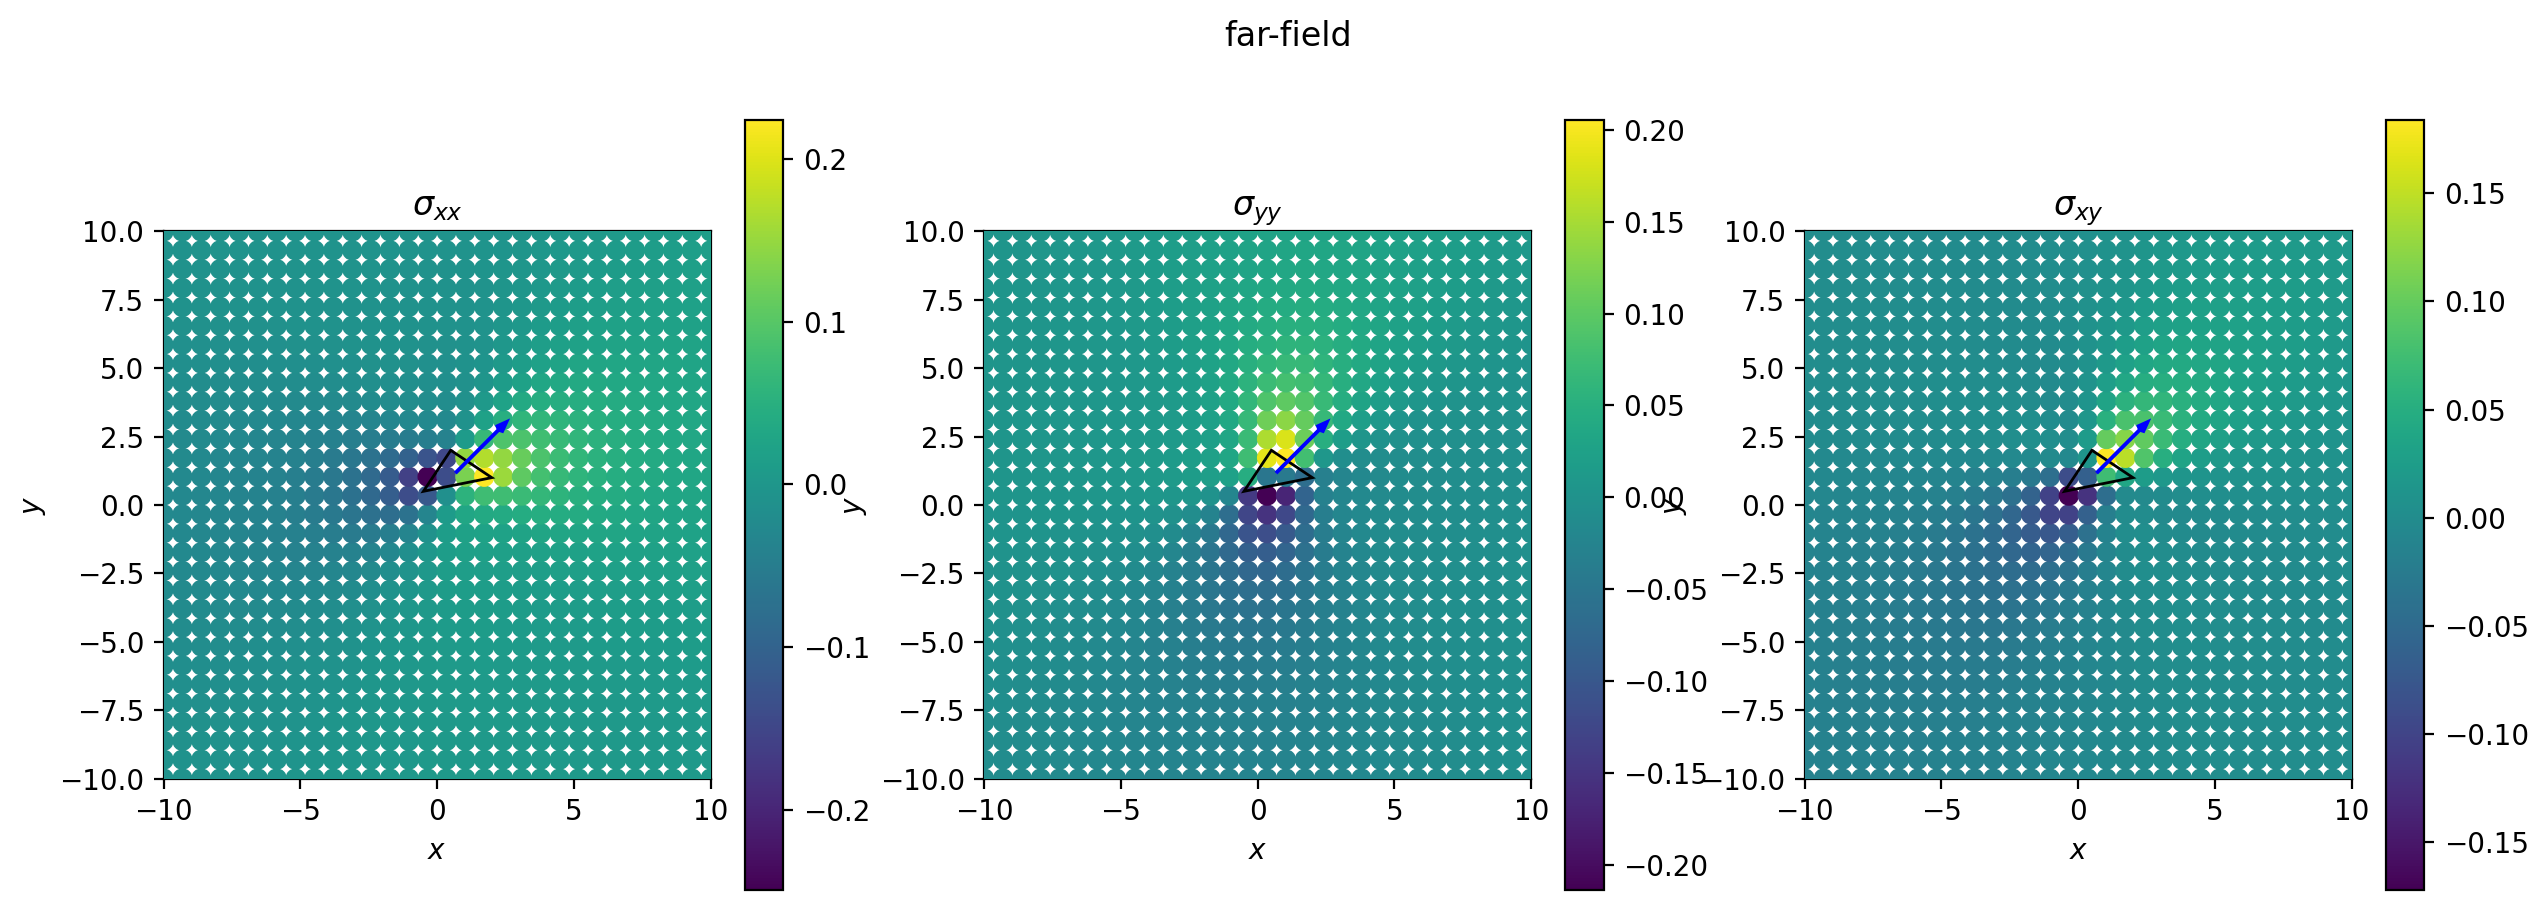

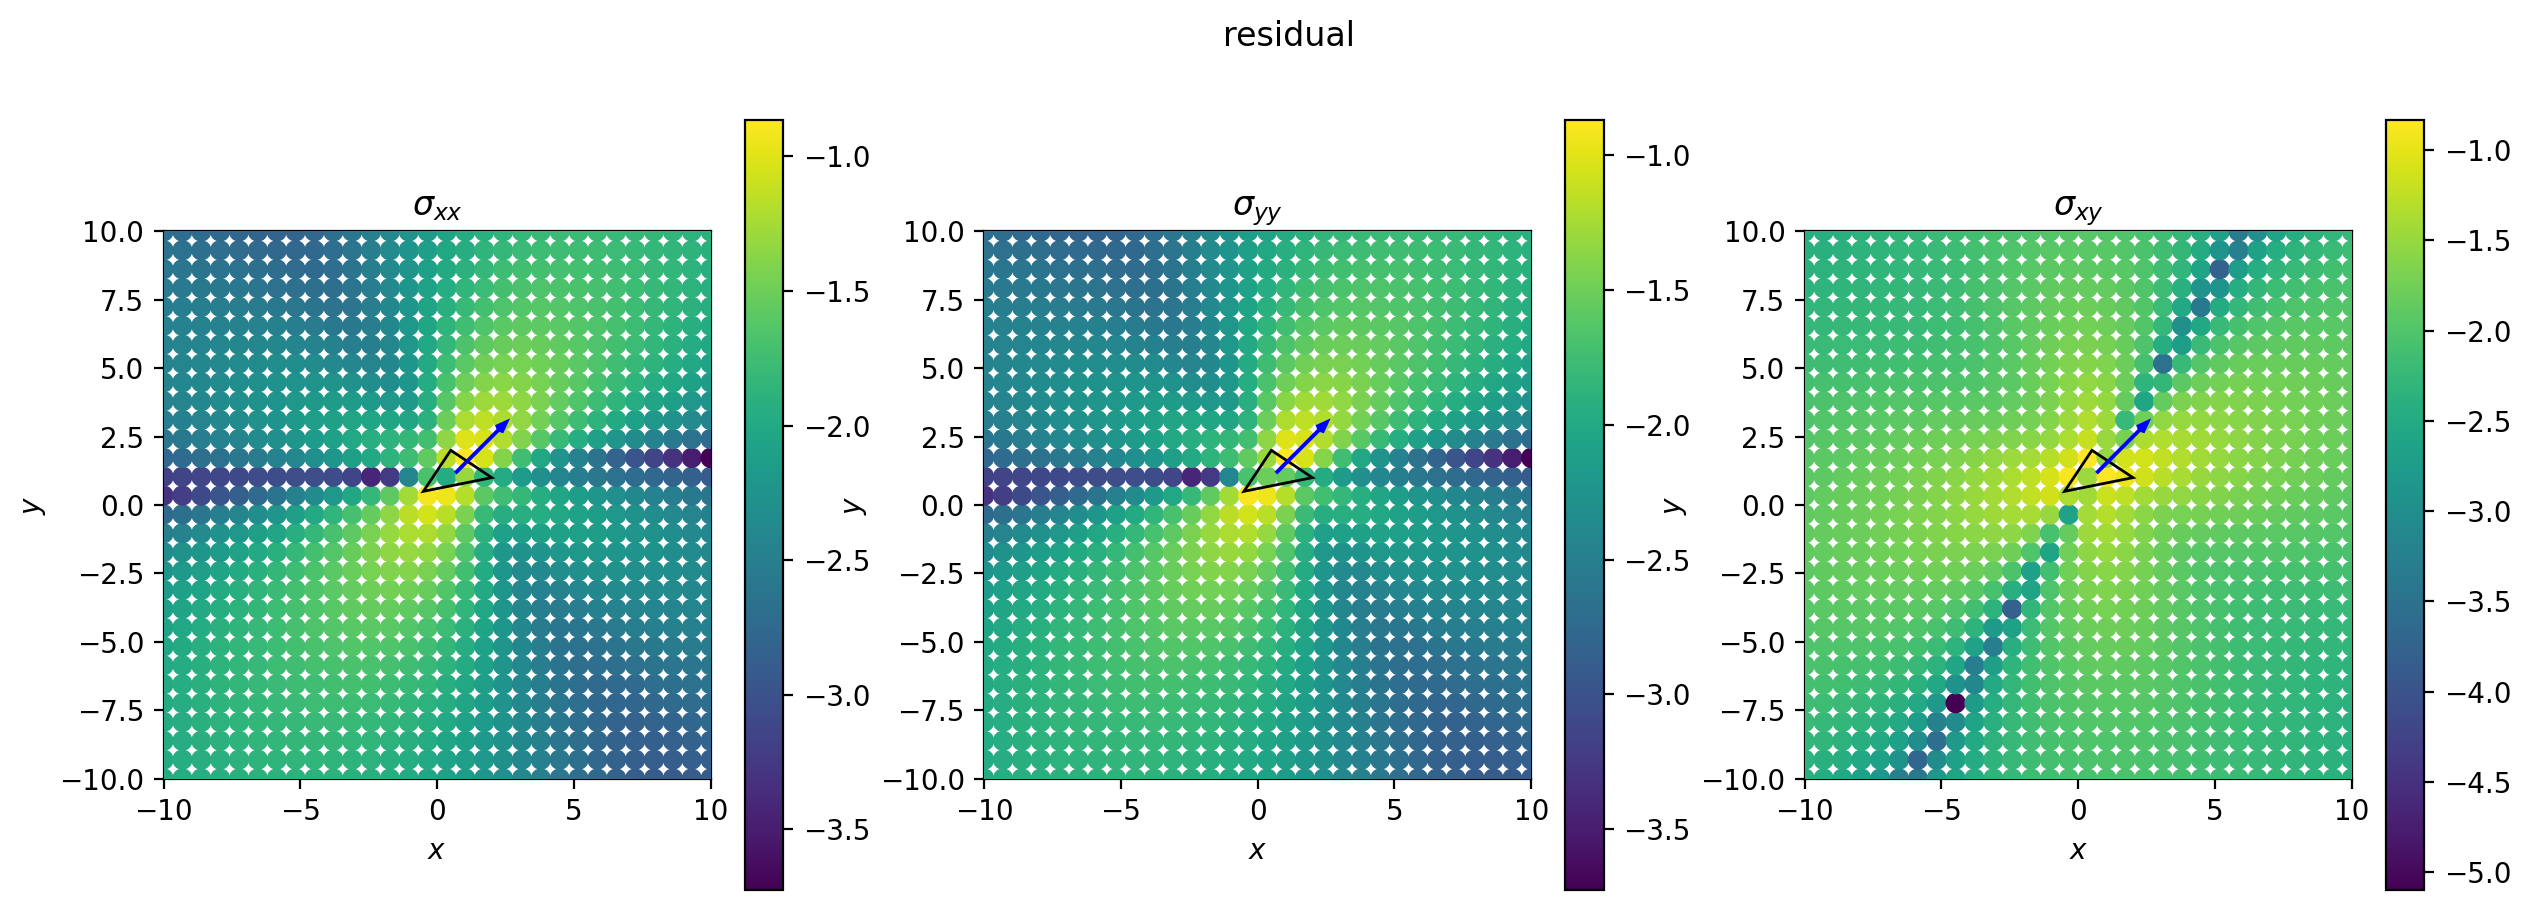

In [5]:
MARKERSIZE = 40


def plot_triangle(vertices):
    plt.fill(vertices[:, 0], vertices[:, 1], color="pink")
    plt.text(
        vertices[0, 0],
        vertices[0, 1],
        "0",
        va="center",
        ha="center",
        backgroundcolor="lightgray",
    )
    plt.text(
        vertices[1, 0],
        vertices[1, 1],
        "1",
        va="center",
        ha="center",
        backgroundcolor="lightgray",
    )
    plt.text(
        vertices[2, 0],
        vertices[2, 1],
        "2",
        va="center",
        ha="center",
        backgroundcolor="lightgray",
    )
    plt.gca().set_aspect("equal", adjustable="box")


def plot_triangle_outline(vertices):
    plt.fill(vertices[:, 0], vertices[:, 1], color="None", edgecolor="k", zorder=50)
    plt.gca().set_aspect("equal", adjustable="box")


def plot_common():
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])


def plot_stresses(sxx, syy, sxy, title_string):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.scatter(x_obs, y_obs, s=MARKERSIZE, c=sxx, zorder=20)
    plt.colorbar()
    plot_triangle_outline(triangle)
    plot_common()
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.quiver(
        np.mean(triangle[:, 0]),
        np.mean(triangle[:, 1]),
        fx,
        fy,
        scale=10.0,
        zorder=100,
        color="blue",
        width=0.007,
        headwidth=3.0,
        headlength=4.0,
    )
    plt.title("$\sigma_{xx}$")

    plt.subplot(1, 3, 2)
    plt.scatter(x_obs, y_obs, s=MARKERSIZE, c=syy, zorder=20)
    plt.colorbar()
    plot_triangle_outline(triangle)
    plot_common()
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.quiver(
        np.mean(triangle[:, 0]),
        np.mean(triangle[:, 1]),
        fx,
        fy,
        scale=10.0,
        zorder=100,
        color="blue",
        width=0.007,
        headwidth=3.0,
        headlength=4.0,
    )
    plt.title("$\sigma_{yy}$")

    plt.subplot(1, 3, 3)
    plt.scatter(x_obs, y_obs, s=MARKERSIZE, c=sxy, zorder=20)
    plt.colorbar()
    plot_triangle_outline(triangle)
    plot_common()
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.quiver(
        np.mean(triangle[:, 0]),
        np.mean(triangle[:, 1]),
        fx,
        fy,
        scale=10.0,
        zorder=100,
        color="blue",
        width=0.007,
        headwidth=3.0,
        headlength=4.0,
    )
    plt.title("$\sigma_{xy}$")
    plt.suptitle(title_string)
    plt.show()


# Plot displacements
plt.figure(figsize=(15, 8))
plt.subplot(1, 3, 1)
plt.quiver(x_obs, y_obs, ux_near, uy_near, color="r", zorder=20)
plot_triangle_outline(triangle)
plot_common()
plt.title("near-field")

plt.subplot(1, 3, 2)
plt.quiver(x_obs, y_obs, ux_far, uy_far, color="r", zorder=20)
plot_triangle_outline(triangle)
plot_common()
plt.title("far-field")

plt.subplot(1, 3, 3)
plt.quiver(x_obs, y_obs, ux_far - ux_near, uy_far - uy_near, color="r", zorder=20)
plot_triangle_outline(triangle)
plot_common()
plt.title("residual")
plt.show()

# Plot stressees
plot_stresses(sxx_near, syy_near, sxy_near, "near-field")
plot_stresses(sxx_far, syy_far, sxy_far, "far-field")
plot_stresses(
    np.log10(np.abs(sxx_near - sxx_far)),
    np.log10(np.abs(syy_near - syy_far)),
    np.log10(np.abs(sxy_near - sxy_far)),
    "residual",
)